### Short description about attempt/idea

### Import libraries

In [1]:
# import dependencies
from torchvision import transforms
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
# from datasets.custom_transforms import unNormalize, decode_segmap

###  Dataset reader

In [2]:
from datasets import cityscapes

In [3]:
# data directory path
data_dir = '../datasets/cityscapes/'
# for augmentation
base_size = 288 # original image resize to 'base_size' dim
crop_size = 256 # finally a random crop is performed and image of 'crop_size' dim is returned

In [4]:
# dataset readers
# additional augmentations are defined inside the reader
dst_train = cityscapes.CityscapesSegmentation(crop_size, base_size, root=data_dir, split='train')

Found 2975 train images


In [5]:
dst_val = cityscapes.CityscapesSegmentation(crop_size, base_size, root=data_dir, split='val')

Found 500 val images


### Dataloader

In [6]:
bs = 42 # maximum possible with image resolution, model size and available
cls_num = 19 # ignoring rare classes which cause class imbalance problem
#Dataloaders
train_loader = DataLoader(dst_train, batch_size=bs, shuffle=True)
val_loader = DataLoader(dst_val, batch_size=bs,shuffle=False)

### Model

In [7]:
# import model
from models.networkT3 import DeepLab

In [8]:
# define which gpu to use
device = torch.device("cuda:5")

In [9]:
# create instance of model
model = DeepLab(num_classes=cls_num)

Downloading: "https://github.com/zhanghang1989/ResNeSt/archive/master.zip" to /home/nipa00002/.cache/torch/hub/master.zip
Using cache found in /home/nipa00002/.cache/torch/hub/zhanghang1989_ResNeSt_master


### Hyper parameters

In [10]:
epochs = 58
lr = 3e-4
mlr = 1e-2
wdk = 4e-5

In [11]:
from torch.optim import Adam, lr_scheduler
# loss function
criterion = torch.nn.CrossEntropyLoss(size_average=True, ignore_index=255) # 255 label assigned to ignored classes
# optimizer
optimizer = Adam(model.parameters(), mlr, (0.9, 0.999),  eps=1e-08, weight_decay=wdk)
# learning rate scheduler (update after every batch)
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=mlr, steps_per_epoch=len(train_loader), epochs=epochs)

/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


### Model Training

In [ ]:
from utils.learn import train_val_loop

model = model.to(device)

loss_train = []
loss_val = []

# perform loops
loss_train, loss_val = train_val_loop(model, epochs, train_loader, val_loader, optimizer, 
                                      criterion, loss_train, 3, bs, device, scheduler)


epoch0, iter0, running loss: 0.0875198103132702
epoch0, iter60, running loss: 0.025418779516852896
epoch0, Training loss: 1.0104147103470815
epoch0, Validation loss: 0.5039363900820414
epoch1, iter0, running loss: 0.015480277084168933
epoch1, iter60, running loss: 0.013011586831287888
epoch1, Training loss: 0.5381001477510157
epoch1, Validation loss: 0.4015345300237338
epoch2, iter0, running loss: 0.012902746597925821
epoch2, iter60, running loss: 0.011956190627873828
epoch2, Training loss: 0.5027136202429382
epoch2, Validation loss: 0.4096009110411008
epoch3, iter0, running loss: 0.008635501776422774
epoch3, iter60, running loss: 0.010848553035521675
epoch3, Training loss: 0.45839822670103797
epoch3, Validation loss: 0.3794664020339648
epoch4, iter0, running loss: 0.010832515500840686
epoch4, iter60, running loss: 0.01031121504576666
epoch4, Training loss: 0.42810890036569516
epoch4, Validation loss: 0.3664625957608223
epoch5, iter0, running loss: 0.010929280803317116
epoch5, iter60, 

epoch43, iter60, running loss: 0.008259466355615626
epoch43, Training loss: 0.3440818400450156
epoch43, Validation loss: 0.2938261864085992
epoch44, iter0, running loss: 0.007151790318034944
epoch44, iter60, running loss: 0.008674604575397631
epoch44, Training loss: 0.36079851548436664
epoch44, Validation loss: 0.3254605531692505
epoch45, iter0, running loss: 0.007608504522414435
epoch45, iter60, running loss: 0.008471076268409027
epoch45, Training loss: 0.3527052209410869
epoch45, Validation loss: 0.29887046789129573
epoch46, iter0, running loss: 0.007387329425130572
epoch46, iter60, running loss: 0.008280980421824905
epoch46, Training loss: 0.3471642858545545
epoch46, Validation loss: 0.2965980072816213
epoch47, iter0, running loss: 0.007675747076670329
epoch47, iter60, running loss: 0.008097724510672314
epoch47, Training loss: 0.3419424572461088
epoch47, Validation loss: 0.28625407939155895
epoch48, iter0, running loss: 0.00791009763876597
epoch48, iter60, running loss: 0.0081016550

In [ ]:
# plot loss curves
x = range(epochs)
plt.title("Plot showing training and validation loss against number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.plot(x, loss_train, color='b', label='Training loss')
plt.plot(x, loss_val, color='r', label='Validation loss')
plt.legend()
plt.savefig('results/T3_loss_curves.png', bbox_inches='tight')
plt.show()

## Visualize results

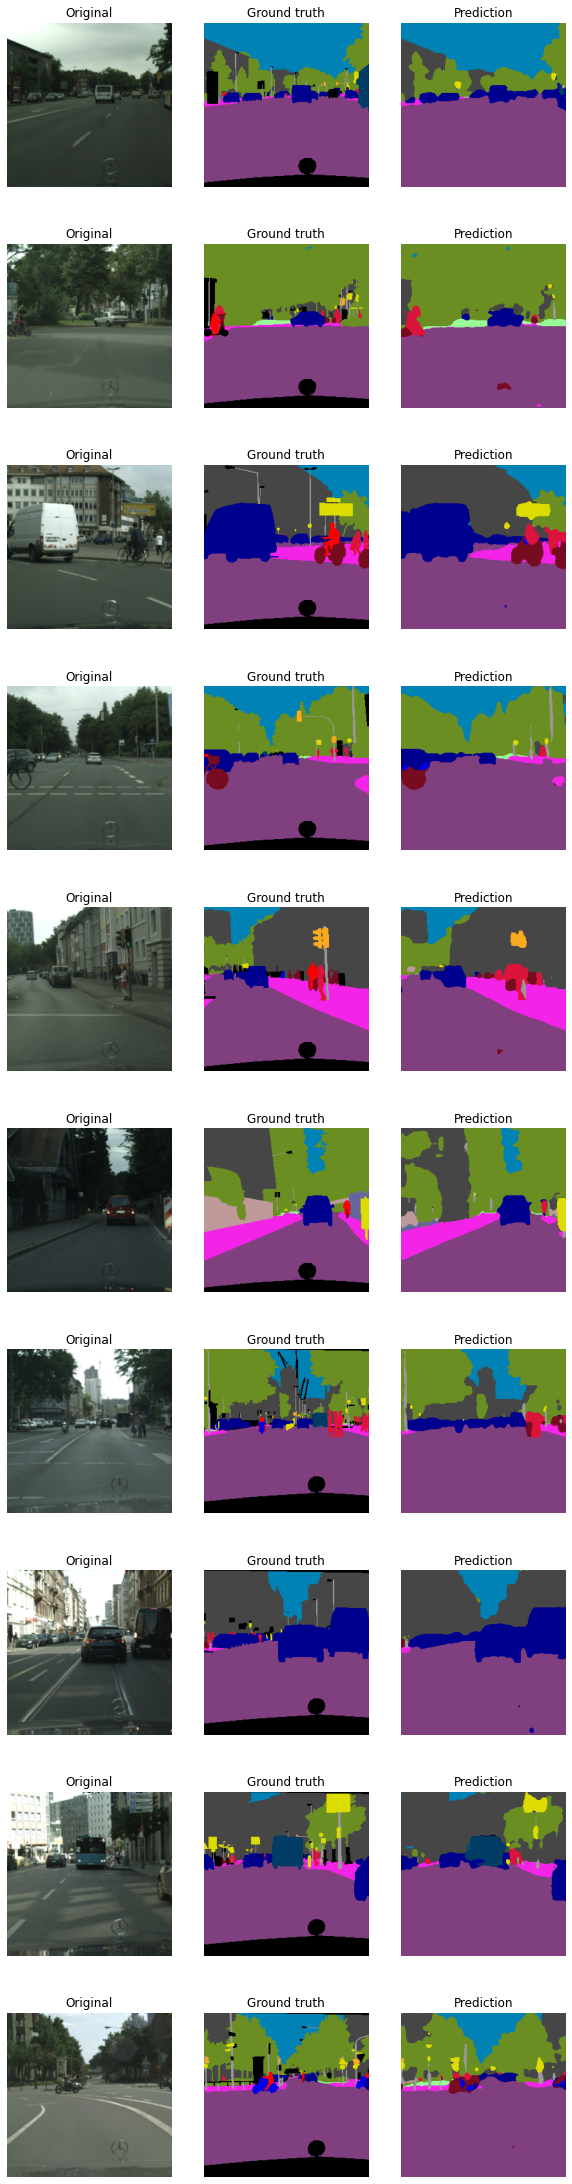

In [13]:
from utils.visual_results import visualize
# epochs=58
# move model to gpu
model = model.to(device)
# load the model states
model.load_state_dict(torch.load(f'../weights/T3/epoch_{epochs-1}.pth')) # please change 'epochs' to the integer value corresponding to weight provided
# perform visualization
visualize(model, val_loader, 'results/T3 results.png', device)

### Evaluate the model

In [ ]:
from utils.eval_metrics import evaluation_loop

# #6 evaluation matrices to be used: sensitivity, specificity, accuracy, AUC, DC and IOU
evaluation_loop(model, val_loader, epochs, device, task=3)

Epochs	 Sensitivity-score Specificity-score Accuracy-score ROC-AUC-score	 Dice score	 IOU score


In [ ]:
# PLOT
df_r = pd.read_csv('results/T3_eval.csv')

X = range(1, len(df_r)+1)
plt.plot(X, df_r.sensitivity, label="sensitivity-score")
plt.plot(X, df_r.specificity, label="specificity-score")
plt.plot(X, df_r.accuracy, label="accuracy-score")
plt.plot(X, df_r.auc, label="AUC-ROC score")
plt.plot(X, df_r.dice, label="Dice coefficient")
plt.plot(X, df_r.iou, label="IOU-Jaccard")

plt.xlabel("Number of epochs")
plt.ylabel("Evaluation metrics score")
plt.title("Performance evalaution")
plt.legend() # add legend
plt.savefig('results/T3_eval_metrics.png', bbox_inches='tight')
plt.show()